In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os, sys, h5py
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sb
import tensorflow as tf
import scipy

from sklearn.metrics import roc_curve, auc, precision_recall_curve

import sys
sys.path.append('../../../..')
import mutagenesisfunctions as mf
import helper 

from Bio import AlignIO
import time as time
import pandas as pd

# Load Data, get base paired indices and remove gaps

In [2]:
starttime = time.time()

#Open data from h5py

data_path = '../../../data_RFAM/glna_100k_d8.hdf5'
with h5py.File(data_path, 'r') as dataset:
    X_data = np.array(dataset['X_data'])
    Y_data = np.array(dataset['Y_data'])
    
numdata, seqlen, _, dims = X_data.shape
dims = dims-1

#remove gaps from sequences
ungapped = True
if ungapped:
    X_data = X_data[:, :, :, :dims]
    
# get validation and test set from training set
test_frac = 0.3
valid_frac = 0.1
N = numdata
split_1 = int(N*(1-valid_frac-test_frac))
split_2 = int(N*(1-test_frac))
shuffle = np.random.permutation(N)

X_train = X_data[shuffle[:split_1], :, 0, :]
X_valid = X_data[shuffle[split_1:split_2], :, 0, :]
X_test = X_data[shuffle[split_2:], :, 0, :]

Y_train = Y_data[shuffle[:split_1]]
Y_valid = Y_data[shuffle[split_1:split_2]]
Y_test = Y_data[shuffle[split_2:]]
    
print ('Data extraction and dict construction completed in: ' + mf.sectotime(time.time() - starttime))

Data extraction and dict construction completed in: 10.97s


In [3]:
simalign_file = '../../../data_RFAM/glnAsim_100k.sto'

#Get the full secondary structure and sequence consensus from the emission
SS = mf.getSSconsensus(simalign_file)
SQ = mf.getSQconsensus(simalign_file)

#Get the ungapped sequence and the indices of ungapped nucleotides
_, ugSS, ugidx = mf.rm_consensus_gaps(X_data, SS)
_, ugSQ, _ = mf.rm_consensus_gaps(X_data, SQ)


#Get the sequence and indices of the conserved base pairs
bpchars = ['(',')','<','>','{','}']
sig_bpchars = ['<','>']
bpidx, bpSS, nonbpidx = mf.sigbasepair(SS, bpchars)
numbp = len(bpidx)
numug = len(ugidx)

#Get the bpug information
bpugSQ, bpugidx = mf.bpug(ugidx, bpidx, SQ)

In [4]:
def unalign(X):
    nuc_index = np.where(np.sum(X, axis=1)!=0)
    return (X[nuc_index])

X_train_unalign = [unalign(X) for X in X_train]
X_valid_unalign = [unalign(X) for X in X_valid]
X_test_unalign = [unalign(X) for X in X_test]

In [5]:
X_train.shape

(120000, 893, 4)

# Build the 2 layer LSTM

In [6]:
tf.reset_default_graph()

num_hidden = 64
num_layers = 2
num_classes = Y_train.shape[1]

# tf Graph input
X = tf.placeholder(tf.float32, [None, None, X_train[0].shape[1]], name='inputs')
Y = tf.placeholder(tf.float32, [None, num_classes], name='ouputs')
keep_prob = tf.placeholder(tf.float32, name='keep_prob')

lstm1_fw_cell = tf.nn.rnn_cell.LSTMCell(num_hidden)#, forget_bias=1.0)
lstm1_fw_cell = tf.contrib.rnn.DropoutWrapper(lstm1_fw_cell, 
                                         output_keep_prob=keep_prob, 
                                         state_keep_prob=1.0,
                                         variational_recurrent=False,
                                         dtype=tf.float32)

lstm1_bw_cell = tf.nn.rnn_cell.LSTMCell(num_hidden)#, forget_bias=1.0)
lstm1_bw_cell = tf.contrib.rnn.DropoutWrapper(lstm1_bw_cell, 
                                         output_keep_prob=keep_prob, 
                                         state_keep_prob=1.0,
                                         variational_recurrent=False,
                                         dtype=tf.float32)

outputs1, states1 = tf.nn.bidirectional_dynamic_rnn(lstm1_fw_cell, lstm1_bw_cell, X, 
                                                   sequence_length=helper.length(X), dtype=tf.float32,
                                                   scope='BLSTM_1')

outputs_forward, outputs_backward = outputs1

# states_forward is a tuple of (c is the hidden state and h is the output)
concat_outputs = tf.concat([outputs_forward, outputs_backward], axis=2, name='intermediate')

lstm2_fw_cell = tf.nn.rnn_cell.LSTMCell(num_hidden)#, forget_bias=1.0)
lstm2_fw_cell = tf.contrib.rnn.DropoutWrapper(lstm2_fw_cell, 
                                         output_keep_prob=keep_prob, 
                                         state_keep_prob=1.0,
                                         variational_recurrent=False,
                                         dtype=tf.float32)

lstm2_bw_cell = tf.nn.rnn_cell.LSTMCell(num_hidden)#, forget_bias=1.0)
lstm2_bw_cell = tf.contrib.rnn.DropoutWrapper(lstm2_bw_cell, 
                                         output_keep_prob=keep_prob, 
                                         state_keep_prob=1.0,
                                         variational_recurrent=False,
                                         dtype=tf.float32)

outputs2, states2 = tf.nn.bidirectional_dynamic_rnn(lstm2_fw_cell, lstm2_bw_cell, concat_outputs,
                                                    scope='BLSTM_2', dtype=tf.float32)

states_forward, states_backward = states2

# states_forward is a tuple of (c is the hidden state and h is the output)
concat_states = tf.concat([states_forward[1], states_backward[1]], axis=1, name='output')

# Linear activation, using rnn inner loop last output
W_out = tf.Variable(tf.random_normal([num_hidden*2, num_classes]))
b_out = tf.Variable(tf.random_normal([num_classes]))

#last = tf.gather(outputs, int(outputs.get_shape()[1])-1)  
#last = int(outputs.get_shape()[1]) - 1
logits = tf.matmul(concat_states, W_out) + b_out
predictions = tf.nn.sigmoid(logits)

In [7]:
# The Optimizer

learning_rate = tf.placeholder(tf.float32, name='learning_rate')

# Define loss and optimizer
predictions = tf.clip_by_value(predictions, clip_value_max=1-1e-7, clip_value_min=1e-7)
#cost = tf.reduce_sum(Y*tf.log(predictions), axis=1)
cost = tf.reduce_sum(Y*tf.log(predictions)+(1-Y)*tf.log(1-predictions), axis=1)

total_loss = tf.reduce_mean(-cost)

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
grads = optimizer.compute_gradients(total_loss)

# Apply gradients.
apply_gradient_op = optimizer.apply_gradients(grads)

# Track the moving averages of all trainable variables.
variable_averages = tf.train.ExponentialMovingAverage(0.9)
variables_averages_op = variable_averages.apply(tf.trainable_variables())

with tf.control_dependencies([apply_gradient_op, variables_averages_op]):
    train_op = tf.no_op(name='train')

# Evaluate model (with test logits, for dropout to be disabled)
#correct_pred = tf.equal(tf.argmax(predictions, 1), tf.argmax(Y, 1))
correct_pred = tf.equal(tf.round(predictions), Y)
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# Train model

In [8]:
dropout_range = [0.2, 0.4, 0.6, 0.8]

for drop in dropout_range:

    # start session
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())

    batch_size = 128
    train_batches = helper.bucket_generator(X_train_unalign, Y_train, batch_size)
    valid_batches = helper.bucket_generator(X_valid_unalign, Y_valid, batch_size)
    num_epochs = 50
    bar_length = 25
    patience = 10


    # path to save results
    save_path = '../../../results/glnA/RNN_trial4'
    if not os.path.isdir(save_path):
        os.mkdir(save_path)
        print("making directory: " + save_path)
    params_filename = 'RNN_t4.%s'%(drop) + '_best'
    params_path = os.path.join(save_path, params_filename)

    wait=0
    min_loss = 1e10
    for epoch in range(num_epochs):
        print('epoch: '+ str(epoch+1))

        num_batches = len(train_batches)
        shuffled_batches = []
        for i in np.random.permutation(num_batches):
            shuffled_batches.append(train_batches[i])

        loss = 0
        acc = 0
        start_time = time.time()
        for i, batch in enumerate(shuffled_batches):
            batch_loss, batch_acc, _ = sess.run([total_loss, accuracy, train_op], feed_dict={X: batch[0], 
                                                                                          Y: batch[1], 
                                                                                          keep_prob: drop,
                                                                                          learning_rate: 0.0003})            
            loss += batch_loss
            acc += batch_acc

            remaining_time = (time.time()-start_time)*(num_batches-(i+1))/(i+1)
            percent = float(i)/num_batches
            progress = '='*int(round(percent*bar_length))
            spaces = ' '*int(bar_length-round(percent*bar_length))
            sys.stdout.write("\r[%s] %.1f%% -- remaining time=%.2fs -- loss=%.5f -- acc=%.5f" \
            %(progress+spaces, percent*100, remaining_time, loss/(i+1), acc/(i+1)))

        sys.stdout.write("\r[%s] %.1f%% -- elapsed time=%.2fs -- loss=%.5f -- acc=%.5f\n" \
        %(progress+spaces, percent*100, time.time()-start_time, loss/(i+1), acc/(i+1)))
        sys.stdout.write("\n")


        num_batches = len(valid_batches)
        loss = 0
        acc = 0
        valid_predictions = []
        valid_truth = []
        start_time = time.time()
        for i, batch in enumerate(valid_batches):
            batch_loss, batch_predict = sess.run([total_loss, predictions], feed_dict={X: batch[0], 
                                                                                    Y: batch[1], 
                                                                                    keep_prob: 1.0})            
            loss += batch_loss
            valid_predictions.append(batch_predict)
            valid_truth.append(batch[1])
        valid_loss = loss/num_batches
        valid_predictions = np.vstack(valid_predictions)
        valid_truth = np.vstack(valid_truth)

        correct = np.mean(np.equal(valid_truth, np.round(valid_predictions)))
        auc_roc, roc_curves = helper.roc(valid_truth, valid_predictions)
        auc_pr, pr_curves = helper.pr(valid_truth, valid_predictions)
        print("  valid loss  = "+str(loss/num_batches))
        print("  valid acc   = "+str(np.nanmean(correct)))
        print("  valid AUROC = "+str(np.nanmean(auc_roc)))
        print("  valid AUPRC = "+str(np.nanmean(auc_pr)))

        # check if current validation loss is lower, if so, save parameters, if not check patience
        if valid_loss < min_loss:
            print("  Lower validation loss found. Saving parameters to: "+params_path)

            # save model parameters
            saver = tf.train.Saver()
            saver.save(sess, save_path=params_path)

            # set minimum loss to the current validation loss
            min_loss = valid_loss

            # reset wait time
            wait = 0
        else:

            # add to wait time
            wait += 1

            # check to see if patience has run out
            if wait == patience:
                print("Patience ran out... early stopping!")
                break
                
    # close tensorflow session (Note, the graph is still open)
    sess.close()

making directory: ../../../results/glnA/RNN_trial4
epoch: 1
[=========================] 99.9% -- elapsed time=119.13s -- loss=0.45746 -- acc=0.7690972

  valid loss  = 0.3416211640663967
  valid acc   = 0.85535
  valid AUROC = 0.9264965354621937
  valid AUPRC = 0.9337926300594204
  Lower validation loss found. Saving parameters to: ../../../results/glnA/RNN_trial4/RNN_t4.0.2_best
epoch: 2
[=========================] 99.9% -- elapsed time=118.13s -- loss=0.32551 -- acc=0.8638166

  valid loss  = 0.2952790166114926
  valid acc   = 0.8798
  valid AUROC = 0.9447328502336088
  valid AUPRC = 0.951170321651708
  Lower validation loss found. Saving parameters to: ../../../results/glnA/RNN_trial4/RNN_t4.0.2_best
epoch: 3
[=========================] 99.9% -- elapsed time=118.20s -- loss=0.29375 -- acc=0.8791584

  valid loss  = 0.27699124251913493
  valid acc   = 0.8879
  valid AUROC = 0.9514122856439515
  valid AUPRC = 0.9571401492084495
  Lower validation loss found. Saving parameters to: ../.

# Test Model

In [9]:
#Open array that will store everything
performance = {'dropout': [],
              'test_loss': [],
              'test_acc': [],
              'test_AUROC': [],
              'test_AUPRC': []}

In [10]:
for drop in dropout_range:

    # create a new session
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())

    # path to save results
    save_path = '../../../results/glnA/RNN_trial4'
    params_filename = 'RNN_t4.%s'%(drop) + '_best'
    params_path = os.path.join(save_path, params_filename)

    # restore trained parameters
    saver = tf.train.Saver()
    saver.restore(sess, save_path=params_path)

    batch_size = 128
    batches = helper.bucket_generator(X_test_unalign, Y_test, batch_size)
    num_batches = len(batches)

    loss = 0
    acc = 0
    valid_predictions = []
    valid_truth = []
    start_time = time.time()
    num_batches = len(batches)
    bar_length = 25

    for i, batch in enumerate(batches):

        batch_loss, batch_predict = sess.run([total_loss, predictions], feed_dict={X: batch[0], 
                                                                                Y: batch[1], 
                                                                                keep_prob: 1.0})            
        loss += batch_loss
        valid_predictions.append(batch_predict)
        valid_truth.append(batch[1])

        remaining_time = (time.time()-start_time)*(num_batches-(i+1))/(i+1)
        percent = float(i)/num_batches
        progress = '='*int(round(percent*bar_length))
        spaces = ' '*int(bar_length-round(percent*bar_length))
        sys.stdout.write("\r[%s] %.1f%% -- remaining time=%.2fs -- loss=%.5f -- acc=%.5f" \
        %(progress+spaces, percent*100, remaining_time, loss/(i+1), acc/(i+1)))

    sys.stdout.write("\r[%s] %.1f%% -- elapsed time=%.2fs -- loss=%.5f -- acc=%.5f\n" \
    %(progress+spaces, percent*100, time.time()-start_time, loss/(i+1), acc/(i+1)))
    sys.stdout.write("\n")

    valid_predictions = np.vstack(valid_predictions)
    valid_truth = np.vstack(valid_truth)

    correct = np.mean(np.equal(valid_truth, np.round(valid_predictions)))
    auc_roc, roc_curves = helper.roc(valid_truth, valid_predictions)
    auc_pr, pr_curves = helper.pr(valid_truth, valid_predictions)
    mean = [np.nanmean(correct), np.nanmean(auc_roc), np.nanmean(auc_pr)]
    std = [np.nanstd(correct), np.nanstd(auc_roc), np.nanstd(auc_pr)]
    
    performance['dropout'].append(drop)
    print("  test loss  = "+str(loss/num_batches))
    performance['test_loss'].append(loss/num_batches)
    print("  test acc   = "+str(np.nanmean(correct)))
    performance['test_acc'].append(np.nanmean(correct))
    print("  test AUROC = "+str(np.nanmean(auc_roc)))
    performance['test_AUROC'].append(np.nanmean(auc_roc))
    print("  test AUPRC = "+str(np.nanmean(auc_pr)))
    performance['test_AUPRC'].append(np.nanmean(auc_pr))

    # close tensorflow session (Note, the graph is still open)
    sess.close()

INFO:tensorflow:Restoring parameters from ../../../results/glnA/RNN_trial4/RNN_t4.0.2_best
[=========================] 99.8% -- elapsed time=21.30s -- loss=0.10048 -- acc=0.0000000

  test loss  = 0.1004804553053747
  test acc   = 0.96385
  test AUROC = 0.9935660723189819
  test AUPRC = 0.9943914501567503
INFO:tensorflow:Restoring parameters from ../../../results/glnA/RNN_trial4/RNN_t4.0.4_best
[=========================] 99.8% -- elapsed time=21.26s -- loss=0.09795 -- acc=0.0000000

  test loss  = 0.09795025797655259
  test acc   = 0.9655666666666667
  test AUROC = 0.9940907494646556
  test AUPRC = 0.9947739673671186
INFO:tensorflow:Restoring parameters from ../../../results/glnA/RNN_trial4/RNN_t4.0.6_best
[=========================] 99.8% -- elapsed time=21.29s -- loss=0.09596 -- acc=0.0000000

  test loss  = 0.09596331877531414
  test acc   = 0.9664833333333334
  test AUROC = 0.9943227129220619
  test AUPRC = 0.9949701598353021
INFO:tensorflow:Restoring parameters from ../../../resu

In [11]:
savepath = 'Arrays/glna_RNNt4_performancedict.npy'
np.save(savepath, performance)

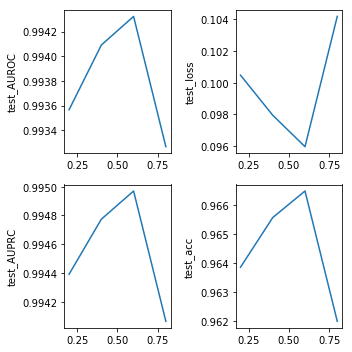

In [43]:
performance = np.load(savepath)
k=1
plt.figure(figsize=(5,5))
keys = performance[()].keys()
keys.pop(keys.index('dropout'))
for key in keys:
    plt.subplot(2,2,k)
    plt.plot(performance[()]['dropout'], performance[()][key])
    plt.ylabel(key)
    k+=1

In [47]:
import pandas as pd
pm = pd.DataFrame(performance[()])
pm

,dropout,test_AUPRC,test_AUROC,test_acc,test_loss
0,0.2,0.994391,0.993566,0.963850,0.100480
1,0.4,0.994774,0.994091,0.965567,0.097950
2,0.6,0.994970,0.994323,0.966483,0.095963
3,0.8,0.994064,0.993267,0.961983,0.104190
